In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2 as cv

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [2]:
DATAPATH = r"C:\Users\yuvfr\proj_university\swedish-leaf-dataset"

In [3]:
def load_image(filename, height=224, width=224):
    img = cv.imread(filename, cv.IMREAD_COLOR)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = cv.resize(img, (height, width))
    return img

data_dict = dict()
classes = [f'leaf{i}' for i in range(1,16)]

for i, leaf in enumerate(classes):
    
    leaf_path = os.path.join(DATAPATH,leaf)
    print(f"load {leaf}")
    leaf_imgs_list = []
    
    for img_fname in os.listdir(leaf_path):
        leaf_imgs_list.append(load_image(os.path.join(leaf_path, img_fname)))
            
            
    data_dict[leaf] = {'data':np.stack(leaf_imgs_list), 'label':np.repeat(i, len(leaf_imgs_list)).reshape(-1,1)}
    
    print(f"{len(leaf_imgs_list)} images","\n")

load leaf1
75 images 

load leaf2
75 images 

load leaf3
75 images 

load leaf4
75 images 

load leaf5
75 images 

load leaf6
75 images 

load leaf7
75 images 

load leaf8
75 images 

load leaf9
75 images 

load leaf10
75 images 

load leaf11
75 images 

load leaf12
75 images 

load leaf13
75 images 

load leaf14
75 images 

load leaf15
75 images 



In [7]:
from mpl_toolkits.axes_grid1 import ImageGrid

In [27]:
for x,y,z in enumerate(zip(list('abc'), [1,2,3])):
    print(x,y,z)

ValueError: not enough values to unpack (expected 3, got 2)

In [34]:
def plot_all_classes(data_dict):
    fig = plt.figure(figsize=(13,20))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 5),  # creates 2x2 grid of axes
#                  axes_pad=0.1,  # pad between axes in inch.
                 )
    idx = np.random.randint(75)
    imgs = [data_dict[f'leaf{i}']['data'][idx,...] for i in range (1,16)]
    title = 1
    for ax, im in zip(grid,imgs):
        ax.imshow(im)
        ax.set_title(str(title))
        title+=1
    
    plt.show()
            

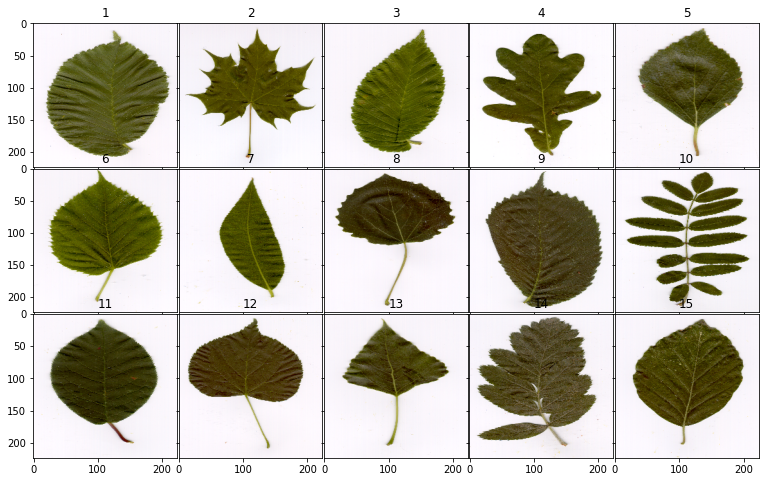

In [35]:
plot_all_classes(data_dict)

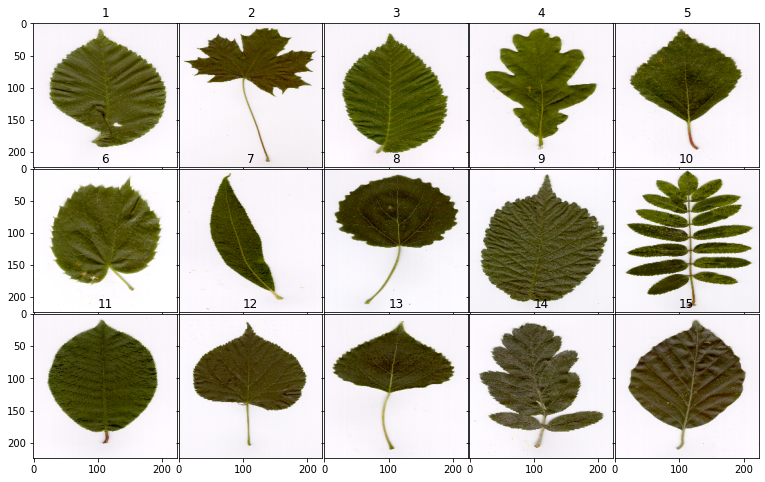

In [37]:
plot_all_classes(data_dict)

In [39]:
from sklearn.decomposition import PCA

In [40]:
data = np.vstack([data_dict[k]['data'] for k in data_dict.keys()])
labels = np.repeat(np.arange(1,16), 75)

In [50]:
data.shape, labels.shape

((1125, 224, 224, 3), (1125,))

In [53]:
flat_data = data.reshape(data.shape[0],-1)

In [61]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=2))])

# pca = PCA(n_components=2)
pcs = pipe.fit_transform(flat_data)

In [113]:
pcs.shape

(1125, 2)

In [117]:

leaf_means = np.vstack([np.mean(pcs[75*i : 75*(i+1)], axis=0) for i in range(15)])

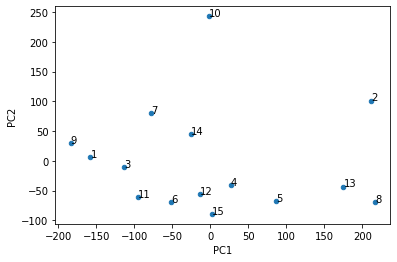

In [121]:
fig, ax = plt.subplots()

pd.DataFrame(leaf_means, index=np.arange(15), columns=[f'PC{i+1}' for i in range(2)]).plot(
    kind='scatter', x=0,y=1, ax=ax)

for i in range(15):
    ax.annotate(str(i+1), (leaf_means[i,0], leaf_means[i,1]))
plt.show()

In [124]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models

import numpy as np
import json
import requests
import matplotlib.pyplot as plt

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for PyTorch')

Using cuda for PyTorch


In [5]:
efficientnet_b0 = models.efficientnet_b0(pretrained=True)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to C:\Users\yuvfr/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

In [ ]:
efficientnet_b0.summ

In [125]:
class AutoEncoder(torch.nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = torch.nn.Conv2d(3,32, (3,3), stride=(2,2))
        self.conv2 = torch.nn.Conv2d(32,64, (3,3), stride=(2,2))
        # self.conv3 = torch.nn.Conv2d(64, 128, (3, 3), stride=(2, 2))

        h_in, w_in = 224, 224
        for conv in [self.conv1,self.conv2]:
            h_in, w_in = self.conv2d_out_shape(
                h_in, w_in, conv.padding, conv.dilation, conv.kernel_size, conv.stride)

        # print(h_in, w_in)
        self.fc = torch.nn.Linear(h_in * w_in * self.conv2.out_channels, 2)

    def forward(self, x):
        batch_size = x.shape[0]
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        # x = F.relu(self.conv3(x))
        # convert to flat
        x = x.view(batch_size, -1)
        return torch.sigmoid(self.fc(x))

    @staticmethod
    def conv2d_out_shape(h_in, w_in, padding, dilation, kernel_size, stride):
        out_dim = lambda dim_in, axis: \
            np.floor((dim_in + 2*padding[axis] - dilation[axis]*(kernel_size[axis]-1) - 1) / stride[0] + 1).astype(int)
        h_out = out_dim(h_in, 0)
        w_out = out_dim(w_in, 1)
        return h_out, w_out

In [126]:
ae = AutoEncoder()

In [168]:
img = data_dict['leaf6']['data'][0]
img = transforms.functional.to_tensor(np.moveaxis(img, -1, -1))
# imgs = torch.from_numpy(np.moveaxis(imgs, -1, 1))
img.shape

torch.Size([3, 224, 224])

In [169]:
out = ae(img.view(-1,*img.shape))

torch.Size([1, 64, 55, 55])
torch.Size([1, 193600])


In [170]:
out

tensor([[0.5307]], grad_fn=<SigmoidBackward0>)

In [173]:
data.shape

(1125, 224, 224, 3)